In [1]:
# This training file has the additional code to train the neural network.
# This file is in .ipynb instead of .py because it has the loss progression that should be shown.

# Imports for torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as T
import torch.nn.functional as F
# Imports for tools
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import timeit
import re
import copy as cp
# Imports for modules
from preprocessing.data_norm import *
from preprocessing.make_idx import *
from preprocessing.make_team_v2 import *
from preprocessing.train_v2 import *


In [2]:
'''
in this cell we choose which device to use, in practice, we find that CPU is much quicker than GPU 
'''
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device = torch.device('cpu')
print_every = 100
print('Using device:', device)


Using device: cpu


In [3]:
# Initializing team names and abbreviations for later use
teamName = ["Atlanta Hawks", "Boston Celtics", "Brooklyn Nets", "Charlotte Bobcats", "Charlotte Hornets",
            "Chicago Bulls", "Cleveland Cavaliers", "Dallas Mavericks", "Denver Nuggets", "Detroit Pistons",
            "Golden State Warriors", "Houston Rockets", "Indiana Pacers", "Los Angeles Clippers", "Los Angeles Lakers",
            "Memphis Grizzlies", "Miami Heat", "Milwaukee Bucks", "Minnesota Timberwolves", "New Jeresy Nets",
            "New Orleans Hornets", "New Orleans Pelicans", "New York Knicks", "Oklahoma City Thunder", "Orlando Magic",
            "Philadelphia 76ers", "Phoenix Suns", "Portland Trail Blazers", "Sacramento Kings", "San Antonio Spurs",
            "Seattle SuperSonics", "Toronto Raptors", "Utah Jazz", "Vancouver Grizzlies", "Washington Bullets",
            "Washington Wizards"]
Abbr = ["ATL", "BOS", "BRK", "CHA", "CHO", "CHI", "CLE", "DAL", "DEN", "DET", "GSW", "HOU", "IND", "LAC", "LAL", "MEM",
        "MIA", "MIL", "MIN", "NJN", "NOH", "NOP", "NYK", "OKC", "ORL", "PHI", "PHO", "POR", "SAC", "SAS", "SEA", "TOR",
        "UTA", "VAN", "WSB", "WAS"]
teamName2019 = ["Atlanta Hawks", "Boston Celtics", "Brooklyn Nets", "Charlotte Hornets",
            "Chicago Bulls", "Cleveland Cavaliers", "Dallas Mavericks", "Denver Nuggets", "Detroit Pistons",
            "Golden State Warriors", "Houston Rockets", "Indiana Pacers", "Los Angeles Clippers", "Los Angeles Lakers",
            "Memphis Grizzlies", "Miami Heat", "Milwaukee Bucks", "Minnesota Timberwolves", "New Orleans Pelicans", 
            "New York Knicks", "Oklahoma City Thunder", "Orlando Magic", "Philadelphia 76ers", "Phoenix Suns", 
            "Portland Trail Blazers", "Sacramento Kings", "San Antonio Spurs", "Toronto Raptors", 
            "Utah Jazz", "Washington Wizards"]
Abbr2019 = ["ATL", "BOS", "BRK", "CHO", "CHI", "CLE", "DAL", "DEN", "DET", "GSW", "HOU", "IND", "LAC", "LAL", "MEM",
        "MIA", "MIL", "MIN", "NOP", "NYK", "OKC", "ORL", "PHI", "PHO", "POR", "SAC", "SAS", "TOR", "UTA", "WAS"]
# Indices of used advanced player metrics (each value corresponds to the index of the column), it correspond to
# 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OBPM','DBPM', 'BPM', 'VORP'
need_idx = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18, 19, 20]


In [4]:
# 25 training years, 5 testing years, optional validation years
trainYear = 25
startYear_train = 1989
validationYear = 0
startYear_validation = startYear_train + trainYear
testYear = 5
startYear_test = startYear_validation + validationYear

# Initialization for training set
player_list_train = [0] * trainYear
winrate_list_train = [0] * trainYear
data_list_train = [0] * trainYear
team_idx_train = [0] * trainYear
data_input_train = [0] * trainYear
loader_train = {}
loader_validation = {}
loader_test = {}

# Creating training data
for index in range(trainYear):
    # Read stats
    playerstats_train = "Player_Data/AvgPlayerStats" + str(index + startYear_train) + ".csv"
    teamstats_train = "Team_Data/TeamStats" + str(index + startYear_train) + ".csv"
    # Convert type
    player_list_train[index] = pd.read_csv(playerstats_train, header=None).values
    winrate_list_train[index] = pd.read_csv(teamstats_train, header=None).values
    # Discard useless columns
    data_list_train[index] = player_list_train[index][:, 4:]
    # Normalization
    data_list_train[index] = data_norm(data_list_train[index])
    # Make abbreviations
    team_idx_train[index] = make_idx(winrate_list_train[index], Abbr, teamName)
    # Put players in same team together
    data_input_train[index] = make_team(player_list_train[index], data_list_train[index], team_idx_train[index],
                                        str(index + startYear_train), device, dtype, need_idx)
    # Put data into dictionary
    loader_train = dict(loader_train, **data_input_train[index])

# Initialization for validation set
player_list_validation = [0] * validationYear
winrate_list_validation = [0] * validationYear
data_list_validation = [0] * validationYear
team_idx_validation = [0] * validationYear
data_input_validation = [0] * validationYear

# Creating validation data
for index in range(validationYear):
    # Read stats
    playerstats_validation = "Player_Data/AvgPlayerStats" + str(index + startYear_validation) + ".csv"
    teamstats_validation = "Team_Data/TeamStats" + str(index + startYear_validation) + ".csv"
    # Convert type
    player_list_validation[index] = pd.read_csv(playerstats_validation, header=None).values
    winrate_list_validation[index] = pd.read_csv(teamstats_validation, header=None).values
    # Discard useless columns
    data_list_validation[index] = player_list_validation[index][:, 4:]
    # Normalization
    data_list_validation[index] = data_norm(data_list_validation[index])
    # Make abbreviations
    team_idx_validation[index] = make_idx(winrate_list_validation[index], Abbr, teamName)
    # Put players in same team together
    data_input_validation[index] = make_team(player_list_validation[index], data_list_validation[index],
                                             team_idx_validation[index], str(index + startYear_validation), device,
                                             dtype, need_idx)
    # Put data into dictionary
    loader_validation = dict(loader_validation, **data_input_validation[index])

# Initialization for testing data
player_list_test = [0] * testYear
winrate_list_test = [0] * testYear
data_list_test = [0] * testYear
team_idx_test = [0] * testYear
data_input_test = [0] * testYear

# Creating testing data
for index in range(testYear):
    # Read stats
    playerstats_test = "Player_Data/AvgPlayerStats" + str(index + startYear_test) + ".csv"
    teamstats_test = "Team_Data/TeamStats" + str(index + startYear_test) + ".csv"
    # Convert type
    player_list_test[index] = (pd.read_csv(playerstats_test, header=None)).values
    winrate_list_test[index] = (pd.read_csv(teamstats_test, header=None)).values
    # Discard useless columns
    data_list_test[index] = player_list_test[index][:, 4:]
    # Normalization
    data_list_test[index] = data_norm(data_list_test[index])
    # Make abbreviations
    team_idx_test[index] = make_idx(winrate_list_test[index], Abbr, teamName)
    # Put players in same team together
    data_input_test[index] = make_team(player_list_test[index], data_list_test[index], team_idx_test[index],
                                       str(index + startYear_test), device, dtype, need_idx)

# Initialization for 2019 data
player_list_2019 = [0]
winrate_list_2019 = [0]
data_list_2019 = [0]
team_idx_2019 = [0]
data_input_2019 = [0]

# Creating 2019 data
# Read stats
playerstats_2019 = "Player_Data/AvgPlayerStats2019.csv"
teamstats_2019 = "Team_Data/TeamStats2019.csv"
# Convert type
player_list_2019[0] = (pd.read_csv(playerstats_2019, header=None)).values
winrate_list_2019[0] = (pd.read_csv(teamstats_2019, header=None)).values
# Discard useless columns
data_list_2019[0] = player_list_2019[0][:, 4:]
# Normalization
data_list_2019[0] = data_norm(data_list_2019[0])
# Make abbreviations
team_idx_2019[0] = make_idx(winrate_list_2019[0], Abbr2019, teamName2019)
# Put players in same team together
data_input_2019[0] = make_team(player_list_2019[0], data_list_2019[0], team_idx_2019[0],
                                   str(2019), device, dtype, need_idx)


In [9]:

'''
This cell trains the network. You can save time and do not have to run this cell because 
the model is already trained and uploaded so we will just load it and save a lot of time.
'''

# Neural network setup
model = None
optimizer = None
# changed by curve method
num_data = 32

# One hidden layer shallow network, bias should be canceled
layer1 = nn.Sequential(
    nn.Linear(num_data, 1, bias=False),
)


model = nn.Sequential(
    layer1
)
# Learning rate can be changed - advised to be less than 1e-1
learning_rate = 1e-3

# Optimizer can be changed, but SGD works well. Weight_decay means to add an L2 regularization
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-5)

#we get the train history to see the train process
his_epoch, his_tra, his_val = train(model, loader_train, loader_validation, device, optimizer, dtype, epochs=400,
                                    print_process=False, early_stop=False)


0 tensor(1.2262, grad_fn=<DivBackward0>)
1 tensor(0.5316, grad_fn=<DivBackward0>)
2 tensor(0.3759, grad_fn=<DivBackward0>)
3 tensor(0.3249, grad_fn=<DivBackward0>)
4 tensor(0.3016, grad_fn=<DivBackward0>)
5 tensor(0.2875, grad_fn=<DivBackward0>)
6 tensor(0.2771, grad_fn=<DivBackward0>)
7 tensor(0.2685, grad_fn=<DivBackward0>)
8 tensor(0.2611, grad_fn=<DivBackward0>)
9 tensor(0.2545, grad_fn=<DivBackward0>)
10 tensor(0.2487, grad_fn=<DivBackward0>)
11 tensor(0.2435, grad_fn=<DivBackward0>)
12 tensor(0.2387, grad_fn=<DivBackward0>)
13 tensor(0.2344, grad_fn=<DivBackward0>)
14 tensor(0.2305, grad_fn=<DivBackward0>)
15 tensor(0.2269, grad_fn=<DivBackward0>)
16 tensor(0.2236, grad_fn=<DivBackward0>)
17 tensor(0.2206, grad_fn=<DivBackward0>)
18 tensor(0.2178, grad_fn=<DivBackward0>)
19 tensor(0.2152, grad_fn=<DivBackward0>)
20 tensor(0.2128, grad_fn=<DivBackward0>)
21 tensor(0.2106, grad_fn=<DivBackward0>)
22 tensor(0.2086, grad_fn=<DivBackward0>)
23 tensor(0.2066, grad_fn=<DivBackward0>)
24

193 tensor(0.1623, grad_fn=<DivBackward0>)
194 tensor(0.1623, grad_fn=<DivBackward0>)
195 tensor(0.1623, grad_fn=<DivBackward0>)
196 tensor(0.1622, grad_fn=<DivBackward0>)
197 tensor(0.1622, grad_fn=<DivBackward0>)
198 tensor(0.1622, grad_fn=<DivBackward0>)
199 tensor(0.1621, grad_fn=<DivBackward0>)
200 tensor(0.1621, grad_fn=<DivBackward0>)
201 tensor(0.1621, grad_fn=<DivBackward0>)
202 tensor(0.1620, grad_fn=<DivBackward0>)
203 tensor(0.1620, grad_fn=<DivBackward0>)
204 tensor(0.1620, grad_fn=<DivBackward0>)
205 tensor(0.1619, grad_fn=<DivBackward0>)
206 tensor(0.1619, grad_fn=<DivBackward0>)
207 tensor(0.1619, grad_fn=<DivBackward0>)
208 tensor(0.1618, grad_fn=<DivBackward0>)
209 tensor(0.1618, grad_fn=<DivBackward0>)
210 tensor(0.1618, grad_fn=<DivBackward0>)
211 tensor(0.1618, grad_fn=<DivBackward0>)
212 tensor(0.1617, grad_fn=<DivBackward0>)
213 tensor(0.1617, grad_fn=<DivBackward0>)
214 tensor(0.1617, grad_fn=<DivBackward0>)
215 tensor(0.1616, grad_fn=<DivBackward0>)
216 tensor(

383 tensor(0.1591, grad_fn=<DivBackward0>)
384 tensor(0.1591, grad_fn=<DivBackward0>)
385 tensor(0.1591, grad_fn=<DivBackward0>)
386 tensor(0.1591, grad_fn=<DivBackward0>)
387 tensor(0.1590, grad_fn=<DivBackward0>)
388 tensor(0.1590, grad_fn=<DivBackward0>)
389 tensor(0.1590, grad_fn=<DivBackward0>)
390 tensor(0.1590, grad_fn=<DivBackward0>)
391 tensor(0.1590, grad_fn=<DivBackward0>)
392 tensor(0.1590, grad_fn=<DivBackward0>)
393 tensor(0.1590, grad_fn=<DivBackward0>)
394 tensor(0.1590, grad_fn=<DivBackward0>)
395 tensor(0.1590, grad_fn=<DivBackward0>)
396 tensor(0.1590, grad_fn=<DivBackward0>)
397 tensor(0.1590, grad_fn=<DivBackward0>)
398 tensor(0.1590, grad_fn=<DivBackward0>)
399 tensor(0.1590, grad_fn=<DivBackward0>)


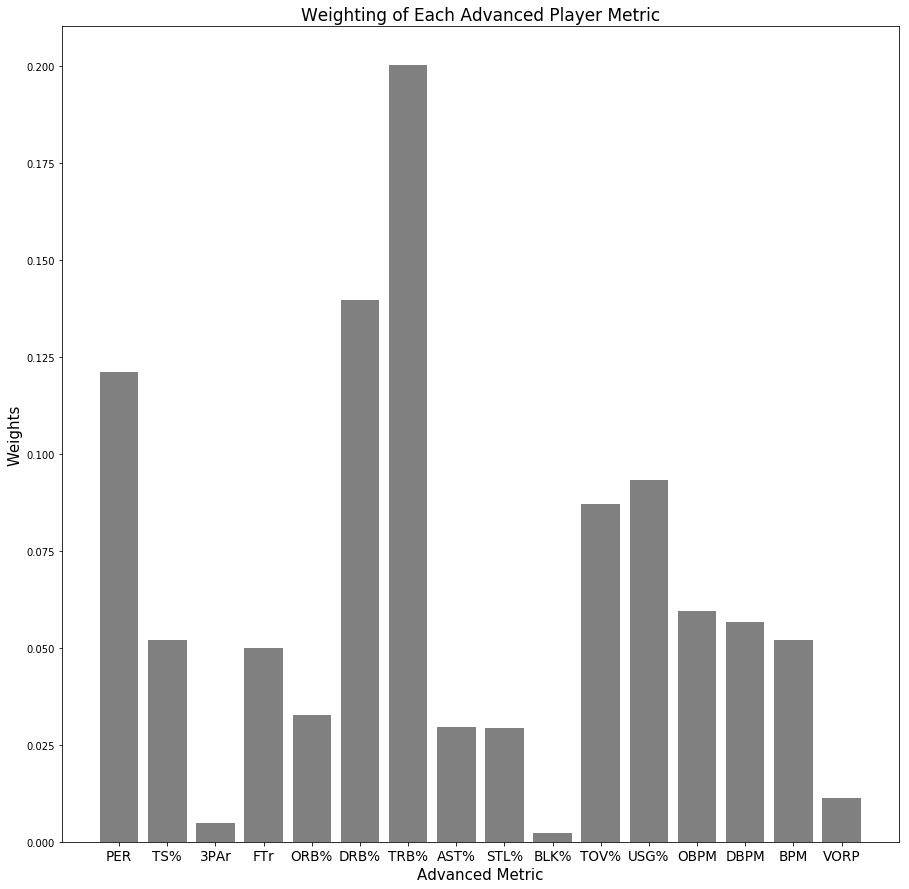

In [10]:
# Visualization of the weights
data_name = ['PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OBPM',
             'DBPM', 'BPM', 'VORP']
weight = abs(model.state_dict()['0.0.weight'][0])
bar_width = 0.8
x_axis = np.arange(len(data_name))
y_axis_1 = tuple(weight[:16])
poly1 = plt.bar(x_axis, y_axis_1, bar_width, color='0.50')
plt.xticks(x_axis, data_name, fontsize=13.5)
plt.title('Weighting of Each Advanced Player Metric', fontsize=17)
plt.xlabel('Advanced Metric', fontsize=15)
plt.ylabel('Weights', fontsize=15)
plt.gcf().set_size_inches(15, 15)


E:\Anaconda\envs\cs231n\lib\site-packages\ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
E:\Anaconda\envs\cs231n\lib\site-packages\ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
E:\Anaconda\envs\cs231n\lib\site-packages\ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
E:\Anaconda\envs\cs231n\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensure

Loss of 2014 : tensor(0.1145)
Loss of 2015 : tensor(0.2037)
Loss of 2016 : tensor(0.1877)
Loss of 2017 : tensor(0.1311)
Loss of 2018 : tensor(0.2121)


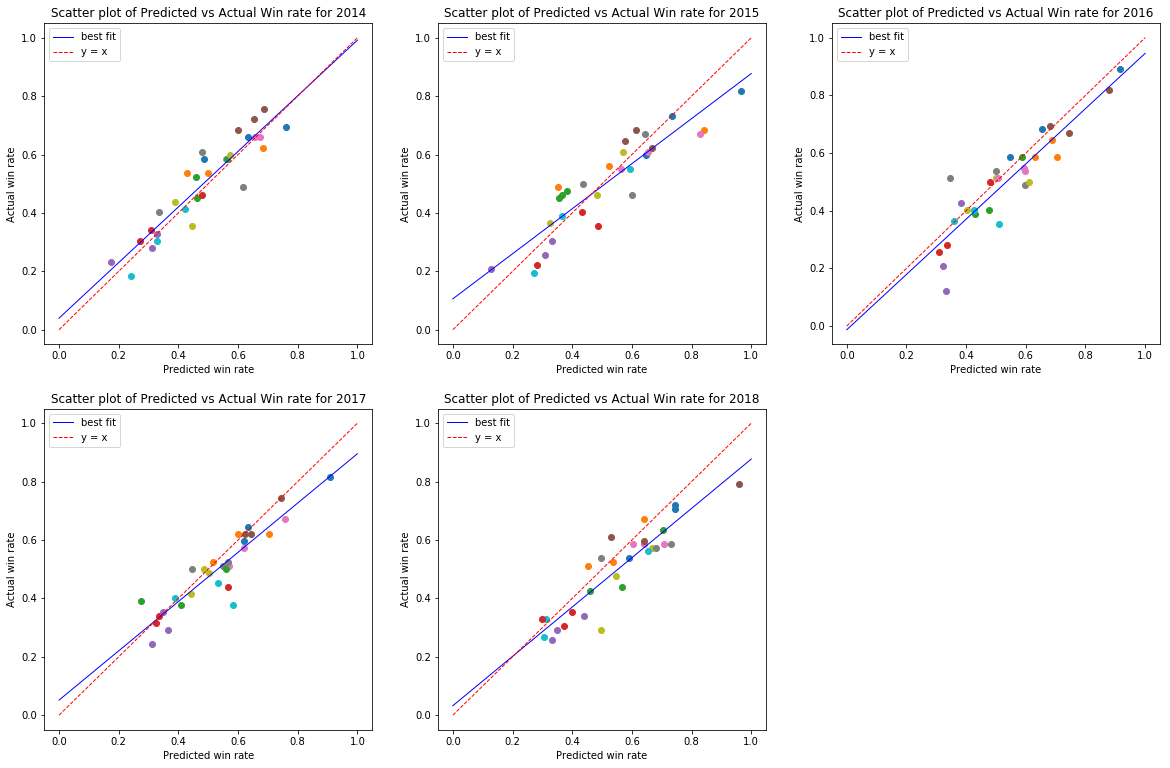

In [12]:
# Display testing set results

# Initializing variables
x = []
y = []
loss = 0
pre_dic = [0] * 5
for i in range(5):
    x = []
    y = []
    loss = 0
    pre_dic[i] = {}
    # Obtain predictions
    for t, content in data_input_test[i].items():
        plt.subplot(2, 3, i + 1)
        PER_C = model(content[0])
        # Loss is the mean square error        
        win_rate = sum(PER_C)
        plt.scatter(win_rate[0].data, content[1][0].data)
        x.append(win_rate[0].data)
        y.append(content[1][0].data)
        loss += (win_rate[0] - content[1][0].data) ** 2
        pre_dic[i][t] = win_rate[0].data

    print("Loss of", i+2014,":", loss.data)
    # Scatter plots of predictions
    z1 = np.polyfit(x, y, 1)
    p1 = np.poly1d(z1)
    x = np.linspace(0, 1, 100)
    y = z1[0] * x + z1[1]
    l1 = plt.plot(x, y, color='blue', linewidth=1.0, label='line')
    x = np.linspace(0, 1, 100)
    y = x
    l2 = plt.plot(x, y, color='red', linewidth=1.0, linestyle='--', label='line')
    plt.gcf().set_size_inches(10, 10)
    plt.gcf().set_size_inches(20, 13)
    plt.ylabel("Actual win rate")
    plt.xlabel("Predicted win rate")
    plt.title("Scatter plot of Predicted vs Actual Win rate for " + str(i + 2014))
    plt.legend(labels=['best fit', 'y = x'], loc='best')


In [ ]:
# please change the file name and format your want to save
torch.save('Models_Figures\Model_new.fit')